### 1. Load data

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.naive_bayes import MultinomialNB, ComplementNB # naive Bayes
from sklearn.linear_model import SGDClassifier # SVM
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
%matplotlib inline

In [2]:
train_fpath = '/home/veera/LST_project/data/train_data.csv'
test_fpath = '/home/veera/LST_project/data/test_data.csv'
labels_col_name = 'Label'
id_col_name = 'id_str'

def download_from_csv(filename):
    # Helper for creating a matrix (ndarray) out of csv data
    df = pd.read_csv(filename, header=0, index_col=id_col_name)
    feature_names = np.asarray(df.columns.values) 
    features = df.drop(labels_col_name, axis=1).values
    labels = df[labels_col_name].values

    return features, labels, feature_names

X_train, y_train, feature_names = download_from_csv(train_fpath)
X_test, y_test, _ = download_from_csv(test_fpath)

print(X_train.shape, X_test.shape)
print(feature_names)

(780, 500) (260, 500)
['across' 'act' 'action' 'actually' 'address' 'agenda' 'ago' 'agree'
 'agreenergoogle' 'air' 'air pollution' 'already' 'also' 'always'
 'america' 'american' 'amp' 'animal' 'announce' 'anyone' 'anything'
 'appreciate' 'apr' 'apr climate' 'april' 'area' 'around' 'article' 'ask'
 'atmosphere' 'attention' 'away' 'back' 'bad' 'bag' 'barackobama' 'base'
 'beautiful' 'become' 'begin' 'believe' 'bernie' 'best' 'biden' 'big'
 'billion' 'bin' 'biodiversity' 'bit' 'blue' 'box' 'building' 'business'
 'call' 'cant' 'car' 'carbon' 'carbon footprint' 'care' 'case' 'cause'
 'challenge' 'change' 'change denial' 'check' 'child' 'china' 'city'
 'claim' 'clean' 'clear' 'climate' 'climate action' 'climate change'
 'climate crisis' 'climate hi' 'climatechange' 'climatecrisis' 'close'
 'co' 'coal' 'come' 'community' 'company' 'consequence' 'consider'
 'content' 'continue' 'control' 'cop' 'corona' 'coronavirus' 'could'
 'country' 'course' 'covid' 'create' 'crisis' 'current' 'cut' 'date' 

### 2. Explorative data analysis

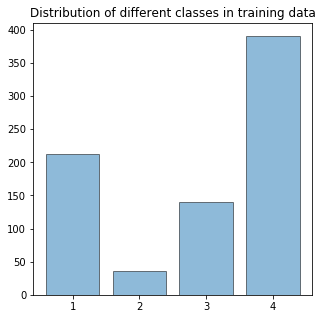

In [3]:
# visualize class distribution
fig1, ax = plt.subplots(1, 1, figsize=(5, 5))
hist = ax.hist(y_train, bins=np.arange(0.5, 5.5, 1), alpha=0.5, ec='black', rwidth=0.8)
ax.xaxis.set_ticks([i for i in range(1, 5)])
ax.set_title('Distribution of different classes in training data')

plt.show()

### 3. Fit model 

In [11]:
# Unbalanced class weights

classifier_nb = ComplementNB()
classifier_sgd = SGDClassifier()

classifier_nb.fit(X_train, y_train)
classifier_sgd.fit(X_train, y_train)

# Balanced class weights

classifier_sgd_balanced = SGDClassifier(class_weight='balanced')

classifier_sgd_balanced.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### 4. Validate

In [36]:
classifiers = [(classifier_nb, 'Naive Bayes'), (classifier_sgd, 'SVM'), (classifier_sgd_balanced, 'SVM with balanced classes')]

for clf, title in classifiers:
    print(title)
    # Prediction accuracy score for testing data
    print("Score: %0.3f" % clf.score(X_test, y_test))
    X = np.vstack((X_train, X_test))
    y = np.hstack((y_train, y_test))
    cv_scores = cross_val_score(clf, X, y)
    print("Cross-validation accuracy: %0.3f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
    y_pred = clf.predict(X_test)
    print("Precision: %0.3f" % precision_score(y_test, y_pred, average='macro'))
    print("Recall: %0.3f" % recall_score(y_test, y_pred, average='macro'))
    print("F1 score: %0.3f" % f1_score(y_test, y_pred, average='macro'))
    print('-' * 50)

Naive Bayes
Score: 0.600
Cross-validation accuracy: 0.599 (+/- 0.05)
Precision: 0.423
Recall: 0.429
F1 score: 0.424
--------------------------------------------------
SVM
Score: 0.631
Cross-validation accuracy: 0.612 (+/- 0.05)
Precision: 0.493
Recall: 0.471
F1 score: 0.477
--------------------------------------------------
SVM with balanced classes
Score: 0.615
Cross-validation accuracy: 0.614 (+/- 0.05)
Precision: 0.456
Recall: 0.443
F1 score: 0.447
--------------------------------------------------


In [37]:
# Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

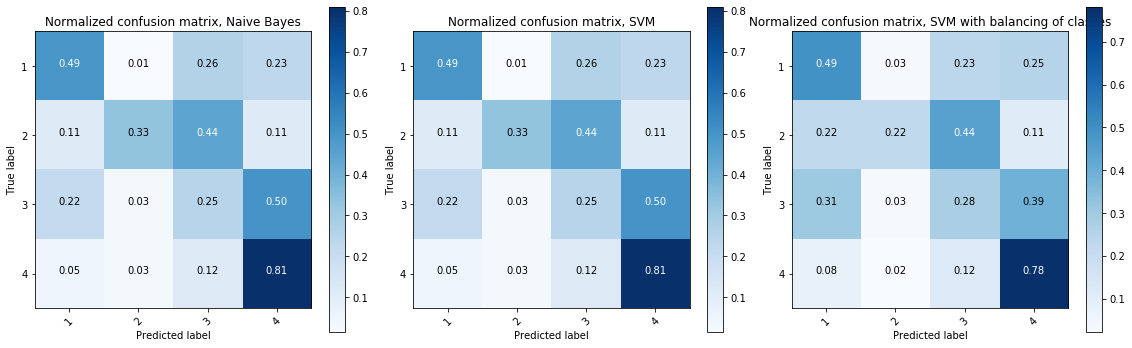

In [38]:
# Compute confusion matrix
class_labels = [str(i+1) for i in range(4)]
y_pred_nb = classifier_sgd.predict(X_test)
y_pred_sgd = classifier_sgd.predict(X_test)
y_pred_sgd_balanced = classifier_sgd_balanced.predict(X_test)
cnf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
cnf_matrix_sgd = confusion_matrix(y_test, y_pred_sgd)
cnf_matrix_sgd_balanced = confusion_matrix(y_test, y_pred_sgd_balanced)
np.set_printoptions(precision=2)

# Plot normalized confusion matrices
plt.figure(figsize=(16, 5))
plt.subplot(131) 
plot_confusion_matrix(cnf_matrix_nb, classes=class_labels, normalize=True,
                      title='Normalized confusion matrix, Naive Bayes')
plt.subplot(132) 
plot_confusion_matrix(cnf_matrix_sgd, classes=class_labels, normalize=True,
                      title='Normalized confusion matrix, SVM')
plt.subplot(133) 
plot_confusion_matrix(cnf_matrix_sgd_balanced, classes=class_labels, normalize=True,
                      title='Normalized confusion matrix, SVM with balancing of classes')

In [39]:
print("Top 10 keywords per class:")
for i in range(4):
    top10 = np.argsort(classifier.coef_[i])[-10:]
    print("%s: %s" % (i+1, ", ".join(feature_names[top10])))

Top 10 keywords per class:
1: climatecrisis, reduction, change denial, google announce, gop, growth, coal, climate action, climate crisis, challenge
2: strong, society, deny, resource, single, huge, ice, model, shit, forward
3: point, fall, within, forward, vote, society, ecological, greenhouse, model, globalwarming
4: hour, beautiful, lo precip, apr climate, date, bag, climate hi, love, seem, market
